In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, 
                             classification_report, roc_curve, auc,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer

In [2]:

# Read the data
df = pd.read_parquet('Package_ML.parquet (1).gzip')

# Filter for specific zip codes
zips = ['37013','37027','37072','37076','37115','37138','37201','37203','37204','37205',
        '37206','37207','37208','37209','37210','37211','37212','37214','37215','37216',
        '37217','37218','37219','37220','37221','37027','37064','37067','37069','37135',
        '37014','37046','37062','37179','37174','37122','37121','37087','37090','37184',
        '37138','37075','37075','37066','37148','37070','37072','37048','37188','37086',
        '37167','37127','37218','37130']
df = df[df['Zip_D'].isin(zips) & df['Zip_O'].isin(zips)]

# Handle missing values for weather data
imputer = SimpleImputer(strategy='mean')
weather_cols = ['TMIN_O', 'TMAX_O', 'PRCP_O', 'SNOW_O', 'TMIN_D', 'TMAX_D', 'PRCP_D', 'SNOW_D']
df[weather_cols] = imputer.fit_transform(df[weather_cols])

# Encode categorical variables
df = pd.get_dummies(df, columns=['ServiceTypeCode', 'MailClassCode', 'Zip_O', 'Zip_D'])

# Separate features and target variable
X = df.drop('late', axis=1)
y = df['late']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc:
        print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)
    
    return model

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000),
    "Naive Bayes": GaussianNB()
}

trained_models = {}
for name, model in models.items():
    trained_models[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)

Random Forest Results:
Accuracy: 0.8903
Precision: 0.7914
Recall: 0.6098
F1 Score: 0.6888
AUC: 0.9221

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2804
           1       0.79      0.61      0.69       697

    accuracy                           0.89      3501
   macro avg       0.85      0.78      0.81      3501
weighted avg       0.88      0.89      0.88      3501

--------------------------------------------------
XGBoost Results:
Accuracy: 0.8872
Precision: 0.8186
Recall: 0.5567
F1 Score: 0.6627
AUC: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2804
           1       0.82      0.56      0.66       697

    accuracy                           0.89      3501
   macro avg       0.86      0.76      0.80      3501
weighted avg       0.88      0.89      0.88      3501

-------------------------------------------------

C:\Users\Evans Sarker\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



K-Means Clustering Results:
Silhouette Score: 0.0765085775914425
Confusion Matrix:
[[ 326 2478]
 [ 136  561]]

Cluster Centers:
   Distinct_event_scans  time_delta_minutes     TMIN_O     TMAX_O    PRCP_O  \
0              1.000000          190.722961   9.423436  33.703210  0.027614   
1              1.000244          179.398680  23.413145  45.512251  0.302706   

     SNOW_O     TMIN_D     TMAX_D    PRCP_D    SNOW_D  ...  Zip_D_37205  \
0  0.286685   8.703943  31.424802  0.031502  0.256174  ...     0.012724   
1  0.100867  22.901525  44.555973  0.304852  0.103336  ...     0.023955   

   Zip_D_37206  Zip_D_37209   Zip_D_37211  Zip_D_37212  Zip_D_37214  \
0     0.015038     0.018508 -1.897354e-19     0.007519     0.010411   
1     0.020451     0.029903  1.629593e-04     0.015644     0.022081   

   Zip_D_37215  Zip_D_37216  Zip_D_37217  Zip_D_37221  
0     0.019665     0.011567     0.027183     0.082128  
1     0.029659     0.019066     0.012303     0.021511  

[2 rows x 148 columns]


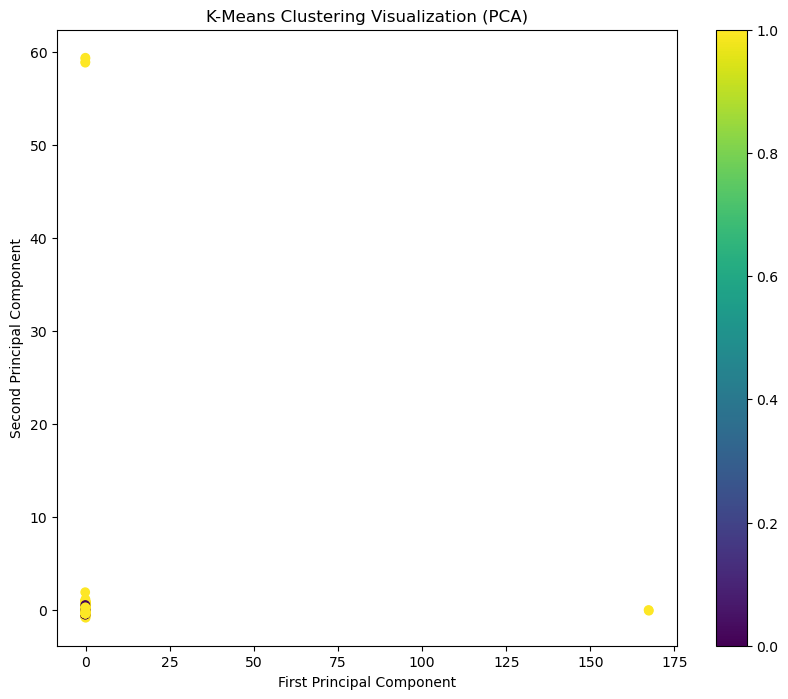


Cluster Accuracy (compared to 'late' label): 0.2534


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, K2Score
from pgmpy.inference import VariableElimination
# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)
cluster_labels = kmeans.predict(X_test_scaled)
print("\nK-Means Clustering Results:")
print("Silhouette Score:", silhouette_score(X_test_scaled, cluster_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, cluster_labels))

# Additional analysis
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_df = pd.DataFrame(cluster_centers, columns=X.columns)
print("\nCluster Centers:")
print(cluster_df)

# Visualize clusters (using first two principal components for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Compare clusters with actual labels
cluster_accuracy = accuracy_score(y_test, cluster_labels)
print(f"\nCluster Accuracy (compared to 'late' label): {cluster_accuracy:.4f}")

In [5]:
# Bayesian Network prep

bn_data = pd.DataFrame({
    'has_snow': (X_test_scaled[:, X.columns.get_loc('SNOW_D')] > 0).astype(int),
    'has_rain': (X_test_scaled[:, X.columns.get_loc('PRCP_D')] > 0).astype(int),
    'late': y_test
})

# Discretize late column
n_bins = 3
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
bn_data['late_discrete'] = discretizer.fit_transform(bn_data[['late']])

# Create mappings for discrete values
snow_map = {0: 'no_snow', 1: 'snow'}
rain_map = {0: 'no_rain', 1: 'rain'}
late_map = {0: 'on_time', 1: 'slightly_late', 2: 'very_late'}

# Apply mappings
bn_data['has_snow'] = bn_data['has_snow'].map(snow_map)
bn_data['has_rain'] = bn_data['has_rain'].map(rain_map)
bn_data['late_discrete'] = bn_data['late_discrete'].map(late_map)

# Create and fit the Bayesian Network model
model = BayesianNetwork([('has_snow', 'late_discrete'), ('has_rain', 'late_discrete')])
model.fit(bn_data[['has_snow', 'has_rain', 'late_discrete']], estimator=BayesianEstimator)

# Perform inference
inference = VariableElimination(model)
query = inference.query(['late_discrete'], evidence={'has_snow': 'snow', 'has_rain': 'rain'})

print("\nBayesian Network Results:")
print("Probability distribution of delivery delays when it's snowing and raining:")
for i, state in enumerate(query.state_names['late_discrete']):
    print(f"{state}: {query.values[i]:.4f}")

# Calculate the most likely outcome
most_likely_index = np.argmax(query.values)
most_likely_outcome = query.state_names['late_discrete'][most_likely_index]
print(f"\nMost likely outcome: {most_likely_outcome}")

# Print the CPDs (Conditional Probability Distributions)
print("\nConditional Probability Distributions:")
for cpd in model.get_cpds():
    print(f"\n{cpd}")


Bayesian Network Results:
Probability distribution of delivery delays when it's snowing and raining:
on_time: 0.9561
very_late: 0.0439

Most likely outcome: on_time

Conditional Probability Distributions:

+-------------------+-----------+
| has_snow(no_snow) | 0.974758  |
+-------------------+-----------+
| has_snow(snow)    | 0.0252424 |
+-------------------+-----------+

+--------------------------+---------------------+---------------------+---------------------+----------------------+
| has_rain                 | has_rain(no_rain)   | has_rain(no_rain)   | has_rain(rain)      | has_rain(rain)       |
+--------------------------+---------------------+---------------------+---------------------+----------------------+
| has_snow                 | has_snow(no_snow)   | has_snow(snow)      | has_snow(no_snow)   | has_snow(snow)       |
+--------------------------+---------------------+---------------------+---------------------+----------------------+
| late_discrete(on_time)   | 0.7

In [ ]:
# Learning Curves and ROC Curves
# Colors f
colors = plt.cm.jet(np.linspace(0, 1, len(trained_models)))

# Learning Curves
plt.figure(figsize=(20, 10))
for (name, model), color in zip(trained_models.items(), colors):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color=color, label=f"{name} (Train)")
    plt.plot(train_sizes, test_scores_mean, 's-', color=color, label=f"{name} (Test)")

plt.title("Learning Curves for All Models")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(20, 10))
for (name, model), color in zip(trained_models.items(), colors):
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Models')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()